# Introduction

In this project we will try to compare the performance between 4 hyperparameter tuning: GridSearchCV, RandomizedSearchCV, BayesSearchCV, and Optuna. We will be using one of the most popular data, california house dataset for simplicty. IQR handling will be used to handle outliers and so we can standardize with StandardScaler for better performance. By the end of the tuning, training/test RMSE, overfitting/undefitting check, and which tunings deliver the best result will be exposed.

In [ ]:
# Import necessary libraries
!pip install scikit-optimize
!pip install optuna
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
# 4 hyperparameter tuning that will be used
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import optuna

#1. Load CSV data

In [ ]:
df=pd.read_csv('1699057012240-california_dataset.csv')

#2. Drop Latitude and Longitude

In [ ]:
df = df.drop(['Latitude', 'Longitude'], axis=1)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,house_price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


#3. Check whether there are any NaN or non float dtype

In [ ]:
for col in df.columns:
  print(df[col].isnull().any())
  print(df[col].dtype)

False
float64
False
float64
False
float64
False
float64
False
float64
False
float64
False
float64


#4. Check the skewness of the data

In [ ]:
from scipy.stats import skew

# Calculate skewness for each column
skewness = df.apply(lambda x: skew(x, nan_policy='omit'))

# 'skewness' is a Pandas Series with skewness values
print(skewness)

MedInc          1.646537
HouseAge        0.060326
AveRooms       20.696365
AveBedrms      31.314680
Population      4.935500
AveOccup       97.632465
house_price     0.977692
dtype: float64


From results above we can see some indication of outliers. IQR Handling will be done here before we proceed further for the standard scaling.

#5. IQR Handling

In [ ]:
def find_outlier_boundary(df, variable):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

for col in [df.columns]:
  upper_limit, lower_limit = find_outlier_boundary(df, col)
  df[col]= np.where(df[col] > upper_limit, upper_limit,
                       np.where(df[col] < lower_limit, lower_limit, df[col]))
# Calculate skewness for each column
skewness = df.apply(lambda x: skew(x, nan_policy='omit'))
# 'skewness' is a Pandas Series with skewness values
print(skewness)

MedInc         0.735565
HouseAge       0.060326
AveRooms       0.348541
AveBedrms      0.462611
Population     0.842186
AveOccup       0.510416
house_price    0.912264
dtype: float64


The skewness has reached a tolerable level in order for us to be able to safely standardize with standard scaler.

#6. Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

#separate features from the target, scaling will only be done on the features
x=df.copy()
y=x.pop('house_price')

#scale the features
standard_scaler=StandardScaler()
x_scaled=standard_scaler.fit_transform(x)
x_scaled=pd.DataFrame(x_scaled,columns=x.columns,index=x.index)
print(x_scaled.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  2.064000e+04  2.064000e+04  2.064000e+04  2.064000e+04  2.064000e+04   
mean  -7.711317e-17  5.508083e-18  2.478637e-16 -6.857564e-16  1.335710e-16   
std    1.000024e+00  1.000024e+00  1.000024e+00  1.000024e+00  1.000024e+00   
min   -1.991479e+00 -2.196180e+00 -2.633335e+00 -2.387314e+00 -1.742525e+00   
25%   -7.466196e-01 -8.453931e-01 -6.933564e-01 -6.448912e-01 -7.184008e-01   
50%   -1.605978e-01  2.864572e-02 -6.067586e-02 -1.140809e-01 -2.233204e-01   
75%    5.684305e-01  6.643103e-01  5.999626e-01  5.167240e-01  5.068904e-01   
max    2.541006e+00  1.856182e+00  2.539941e+00  2.259147e+00  2.344827e+00   

           AveOccup  
count  2.064000e+04  
mean  -1.156697e-16  
std    1.000024e+00  
min   -2.530199e+00  
25%   -6.799133e-01  
50%   -1.179684e-01  
75%    5.536104e-01  
max    2.403896e+00  


#7. Lasso Baseline Model

In [ ]:
#preparing train and test data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

#creating baseline model
lasso_model = Lasso() #Lasso
lasso_model.fit(x_train, y_train)

Lasso()

#8. Baseline Prediction

In [ ]:
#try to predict training rmse using baseline model
y_train_pred_lasso = lasso_model.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using baseline model
y_pred_lasso = lasso_model.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 1.1340426341838947
RMSE on Testing Data (Lasso): 1.1245508304576213


In [ ]:
print(y_train.describe())
print(y_test.describe())

count    16512.000000
mean         2.063027
std          1.134077
min          0.149990
25%          1.198000
50%          1.798500
75%          2.651250
max          4.824125
Name: house_price, dtype: float64
count    4128.000000
mean        2.046952
std         1.124572
min         0.149990
25%         1.192750
50%         1.786500
75%         2.630000
max         4.824125
Name: house_price, dtype: float64


With target mean of ~2.06, after applying feature scaling our RMSE doesn't look very good. But we shall see what happen when we apply hyperparameter tuning.

#9.a. Hyperparameter Tuning: Grid Search

In [ ]:
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],
    'tol': [0.0001, 0.001, 0.01],
    'selection': ['cyclic','random'],
    'warm_start':[False, True]
}

# Set refit=True so we don't have to fit the best parameters again later
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
print("Parameter Terbaik:", grid_search.best_params_)

Parameter Terbaik: {'alpha': 0.1, 'selection': 'random', 'tol': 0.01, 'warm_start': False}


In [ ]:
lasso_grid_best = Lasso(**grid_search.best_params_)
lasso_grid_best.fit(x_train, y_train)

Lasso(alpha=0.1, selection='random', tol=0.01)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_grid_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_grid_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7589108077527761
RMSE on Testing Data (Lasso): 0.7683522624205623


Significant decrease in RMSE from ~1.1 to ~0.75 was observed. With the similarity between training and test RMSE, the model seems to be good (not underfitting/overfitting). Let's confirm this with the learning curve.

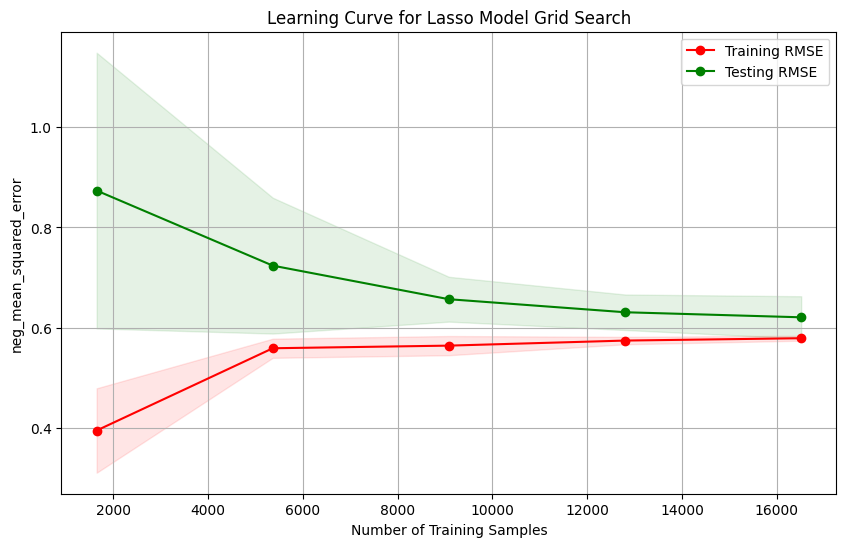

In [ ]:
def plot_learning_curve(model, X, y, cv, scoring, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Number of Training Samples")
    plt.ylabel("neg_mean_squared_error")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing RMSE")

    plt.legend(loc="best")
    plt.show()
plot_learning_curve(lasso_grid_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Grid Search")

The rmse curve for training and test predictions converged. This means that no overfitting or underfitting has occured.

#9.b. Hyperparameter Tuning: Random Search

In [ ]:
random_search = RandomizedSearchCV(lasso_model, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=10)
random_search.fit(x_train, y_train)
print("Parameter Terbaik:", random_search.best_params_)

Parameter Terbaik: {'warm_start': True, 'tol': 0.001, 'selection': 'random', 'alpha': 0.1}


In [ ]:
lasso_random_best = Lasso(**random_search.best_params_)
lasso_random_best.fit(x_train, y_train)

Lasso(alpha=0.1, selection='random', tol=0.001, warm_start=True)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_random_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_random_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7601699041049774
RMSE on Testing Data (Lasso): 0.7695497958600451


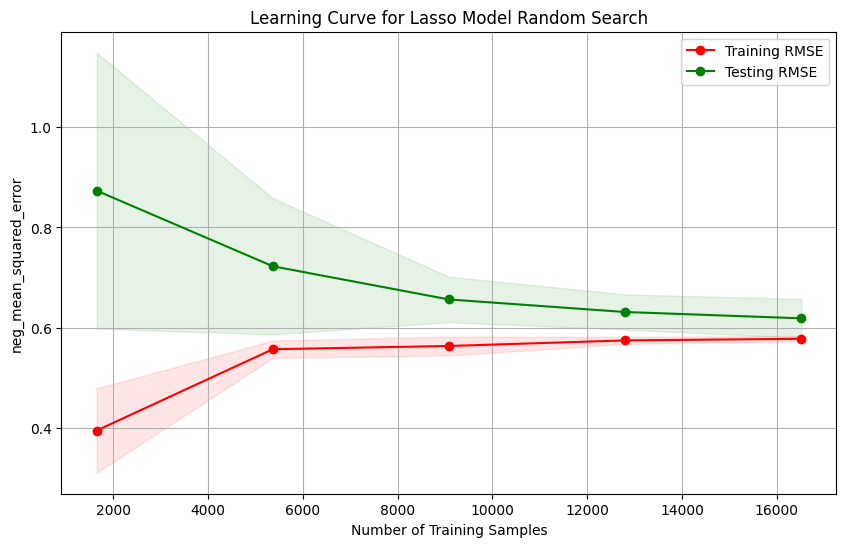

In [ ]:
plot_learning_curve(lasso_random_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Random Search")

Same case with grid search, although grid search produced marginally lower RMSE. This is acceptable since grid search is more thorough in their best parameter search.

#9.c. Hyperparameter Tuning: Bayesian Search

In [ ]:
bayes_search = BayesSearchCV(
    estimator=lasso_model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=100,
    n_jobs=-1 #set to -1 to ensure using max amount of CPU cores
)

bayes_search.fit(x_train,y_train)
print("Parameter Terbaik:", bayes_search.best_params_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Parameter Terbaik: OrderedDict([('alpha', 0.1), ('selection', 'random'), ('tol', 0.01), ('warm_start', True)])


In [ ]:
lasso_bayes_best = Lasso(**bayes_search.best_params_)
lasso_bayes_best.fit(x_train, y_train)

Lasso(alpha=0.1, selection='random', tol=0.01, warm_start=True)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_bayes_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_bayes_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7601092098181753
RMSE on Testing Data (Lasso): 0.7694978384353758


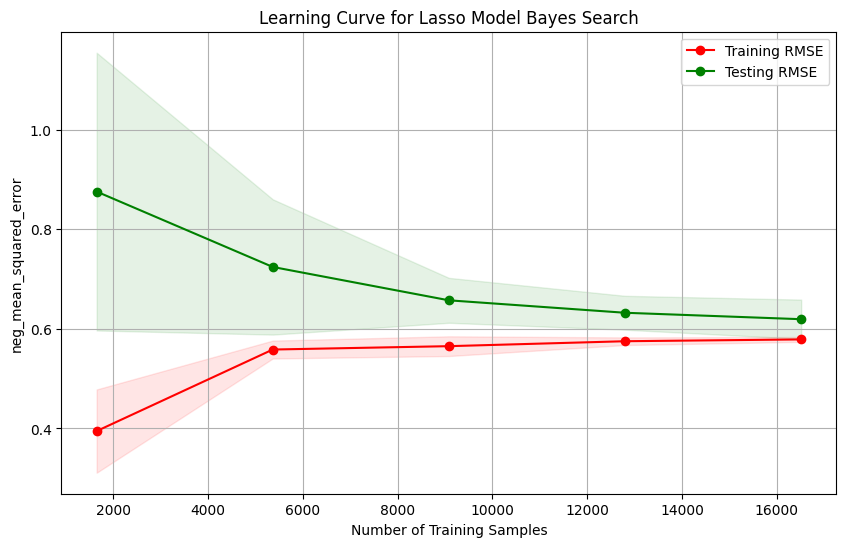

In [ ]:
plot_learning_curve(lasso_bayes_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Bayes Search")

Same case with grid and random search. So far grid search is still the best model with the lowest RMSE.

#9.d. Hyperparameter Tuning: Optuna

In [ ]:
def objective(trial):
  alpha = trial.suggest_float('alpha', 0.1, 10.0, log=True)
  tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
  selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
  warm_start = trial.suggest_categorical('warm_start', [True, False])
  lasso = Lasso(alpha=alpha, tol=tol, selection=selection, warm_start=warm_start)
  lasso.fit(x_train, y_train)
  y_pred = lasso.predict(x_test)
  return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f"Best Parameters: {study.best_params}")
print(f"Best Mean Squared Error: {study.best_value}")

[I 2023-11-07 04:47:31,183] A new study created in memory with name: no-name-b9ff4604-f22e-47b4-a99d-f5f70cc571fb
[I 2023-11-07 04:47:31,197] Trial 0 finished with value: 1.264614570282926 and parameters: {'alpha': 4.49114721382272, 'tol': 0.0021427438944217605, 'selection': 'random', 'warm_start': False}. Best is trial 0 with value: 1.264614570282926.
[I 2023-11-07 04:47:31,209] Trial 1 finished with value: 1.264614570282926 and parameters: {'alpha': 0.8447843510887563, 'tol': 0.00014416035637043192, 'selection': 'cyclic', 'warm_start': False}. Best is trial 0 with value: 1.264614570282926.
[I 2023-11-07 04:47:31,220] Trial 2 finished with value: 1.264614570282926 and parameters: {'alpha': 0.9087583431533796, 'tol': 0.001087383640856808, 'selection': 'cyclic', 'warm_start': True}. Best is trial 0 with value: 1.264614570282926.
[I 2023-11-07 04:47:31,232] Trial 3 finished with value: 1.264614570282926 and parameters: {'alpha': 0.9565627498851609, 'tol': 0.006841664056351384, 'selection

Best Parameters: {'alpha': 0.10012999841920746, 'tol': 0.00021559719309263397, 'selection': 'cyclic', 'warm_start': False}
Best Mean Squared Error: 0.5922786751061544


In [ ]:
lasso_optuna_best = Lasso(**study.best_params)
lasso_optuna_best.fit(x_train, y_train)

Lasso(alpha=0.10012999841920746, tol=0.00021559719309263397)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_optuna_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_optuna_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7602209688183553
RMSE on Testing Data (Lasso): 0.7695964365212162


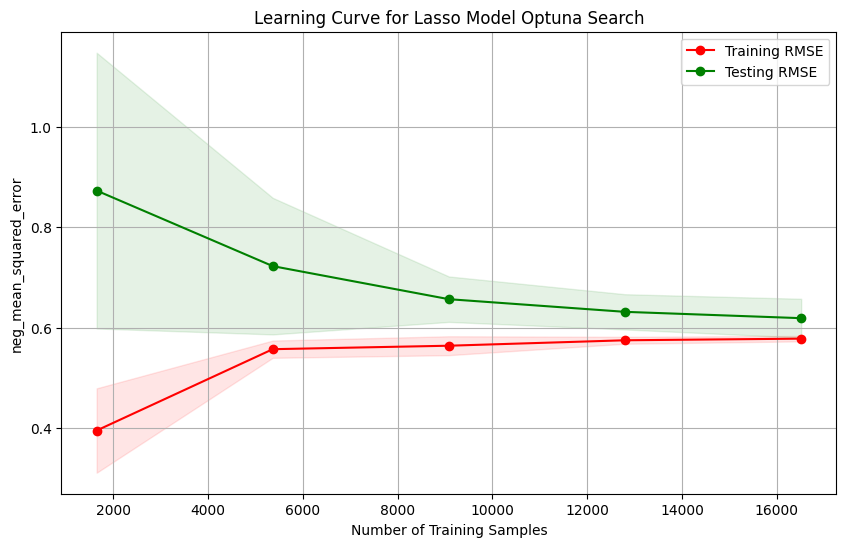

In [ ]:
plot_learning_curve(lasso_optuna_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Optuna Search")

Optuna tuning has also done very well. However interesting finding is that it is marginally outperformed by Grid search. We will uncover this in the Conclusion section.

#10. Conclusion

Let's recap our train/test RMSE results for each hyperparameter tuning.

a. Grid Search<br>
RMSE on Training Data (Lasso): 0.7589108077527761<br>
RMSE on Testing Data (Lasso): 0.7683522624205623

b. Random Search<br>
RMSE on Training Data (Lasso): 0.7601699041049774<br>
RMSE on Testing Data (Lasso): 0.7695497958600451<br>

c. Bayes Search<br>
RMSE on Training Data (Lasso): 0.7601092098181753<br>
RMSE on Testing Data (Lasso): 0.7694978384353758<br>

d. Optuna<br>
RMSE on Training Data (Lasso): 0.7602209688183553<br>
RMSE on Testing Data (Lasso): 0.7695964365212162<br>

It was observed that all tunings are equally good though Grid Search marginally produced the best result which is a bit weird because Optuna should be the best one since it is the only tuning that can accept continous parameter grid for alpha and tolerance. Let's check out again parameter grid used for Grid and Optuna.

Grid Parameters:<br>
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],
    'tol': [0.0001, 0.001, 0.01],
    'selection': ['cyclic','random'],
    'warm_start':[False, True]
}

Optuna Parameters:<br>
  alpha = trial.suggest_float('alpha', 0.1, 10.0, log=True)<br>
  tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)<br>
  selection = trial.suggest_categorical('selection', ['cyclic', 'random'])<br>
  warm_start = trial.suggest_categorical('warm_start', [True, False])<br>

One possible explanation is that Optuna tuning is a bit of luck based where the more trials we had, the more likely it will find the best iteration result. Perhaps 100  amount of trials were not enough to make Optuna "fine-grained" enough to outperform Grid.